In [1]:
import chemprop
import pandas as pd
import numpy as np
from utils import utils

In [3]:
main = pd.read_csv(r'./data/train_dm300_full.csv')

In [4]:
main['full_smiles'] = [str(solute) + "." + str(solvent) for (solute, solvent) in zip(main['solute_smiles'], main['solvent_smiles'])]

In [41]:
solvents = ["MeOH", "EtOH", "IPA", "Tol", "Hept", "Acet", "MeCN", "MTBE", "MeTHF", "DMF", "EtOAc"]
solvent_names = {"Methanol":"Methanol", 
                "Ethanol":"Ethanol", 
                "2-Propanol":"2-Propanol", 
                "Toluene":"Toluene", 
                "Heptane":"Heptane", 
                "Acetone":"Acetone", 
                "Acetonitrile":"Acetonitrile", 
                "Methyl tert butyl ether":"Methyl\ntert-butyl ether", 
                "2-Methly tetrahydrofurane":"2-Methyl\ntetrahydrofurane",
                "Dimethyl formamide":"Dimethyl\nformamide", 
                "Etyl acetate":"Ethyl\nacetate" }

solvent_dict = {}
for solvent, name in zip(solvents, solvent_names.keys()):
    solvent_dict[solvent] = original[original['solvent_name']==name]

In [5]:
main.to_csv(r'./data/_final_2.csv')

In [71]:
solvent_dict['DMF'].to_csv(r'./data/_dmf.csv')
len(solvent_dict['DMF'])

123

In [7]:
for i in range(1):
    print(f'{i}th cycle')
    arguments = [
        '--data_path', './data/_final_2.csv',
        '--dataset_type', 'regression',
        '--save_dir', './data/train_results/_temp/',
        '--metric', 'rmse',
        '--extra_metrics', 'r2',
        '--quiet',
        '--split_sizes', '0.795', '0.2', '0.005',
        '--target_columns', 'dm300',
        '--smiles_column', 'full_smiles',
        '--epochs', '60'
        ]

    args = chemprop.args.TrainArgs().parse_args(arguments)
    mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

    arguments = [
        '--test_path',  './data/_final_2.csv',
        '--preds_path', './data/predictions/temp_final_2.csv',
        '--checkpoint_dir', './data/train_results/_temp/',
        '--smiles_column', 'full_smiles'
        ]

    args = chemprop.args.PredictArgs().parse_args(arguments)
    preds = chemprop.train.make_predictions(args=args)

    original = pd.read_csv(r'./data/_final_2.csv')
    print('#############################')
    print('ORIGINAL',len(original))
    temp = pd.read_csv(r'./data/predictions/temp_final_2.csv')
    print('#############################')
    print('TEMP',len(original))

    temp.rename(columns={'dm300':'dm300_pred'}, inplace=True)
    temp['dm300_pred'].mask(temp['dm300_pred'] > 1., 1., inplace=True)
    # original['dm300_err'] = np.divide(np.subtract(temp['dm300_pred'], original['dm300']), original['dm300'])
    original['dm300_err'] = np.abs(np.subtract(temp['dm300_pred'], original['dm300']))

    # original['global_err'] = np.abs(np.divide(np.add(original['dm300_err'], np.add(original['d'], np.add(original['co2_err'], np.add(original['o2_err'], np.add(original['n2_err'], original['ch4_err']))))), 6))
    original['dm300_pred'] = temp['dm300_pred']    
    original = original.sort_values('dm300_err', ascending=False)
    original = original[5:]

    original.to_csv(r'./data/_final_2.csv', sep=',')


0th cycle


1167it [00:00, 209589.48it/s]
100%|██████████| 1167/1167 [00:00<00:00, 16025.83it/s]
Fold 0
100%|██████████| 60/60 [00:42<00:00,  1.43it/s]
Model 0 best validation rmse = 0.166202 on epoch 50
Model 0 test rmse = 0.255343         
Model 0 test r2 = 0.673140
Ensemble test rmse = 0.255343
Ensemble test r2 = 0.673140
1-fold cross validation
	Seed 0 ==> test rmse = 0.255343
	Seed 0 ==> test r2 = 0.673140
Overall test rmse = 0.255343 +/- 0.000000
Overall test r2 = 0.673140 +/- 0.000000
Elapsed time = 0:00:43
1167it [00:00, 289424.83it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

Loading training args
Loading data
Validating SMILES
Test size = 1,167
Predicting with an ensemble of 1 models
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".


100%|██████████| 1/1 [00:46<00:00, 46.85s/it]

Saving predictions to ./data/predictions/temp_final_2.csv
Elapsed time = 0:00:47
#############################
ORIGINAL 1167
#############################
TEMP 1167


In [84]:
meoh = pd.read_csv(r'./data/_meoh.csv')
mecn = pd.read_csv(r'./data/_mecn.csv')
dmf = pd.read_csv(r'./data/_dmf.csv')

In [85]:
total = pd.concat([mecn, dmf, meoh])

In [86]:
temp = original

In [87]:
temp = temp[temp['solvent_name']!='Acetonitrile']
temp = temp[temp['solvent_name']!='Methanol']
temp = temp[temp['solvent_name']!='Dimethyl formamide']

In [88]:
full_list = pd.concat([temp, total])

In [89]:
len(full_list)

1032

In [90]:
full_list.to_csv(r'./data/FINAL_LIST.csv')

In [97]:
meoh = pd.read_csv(r'./data/_FINAL_LIST.csv')
len(meoh)

1032

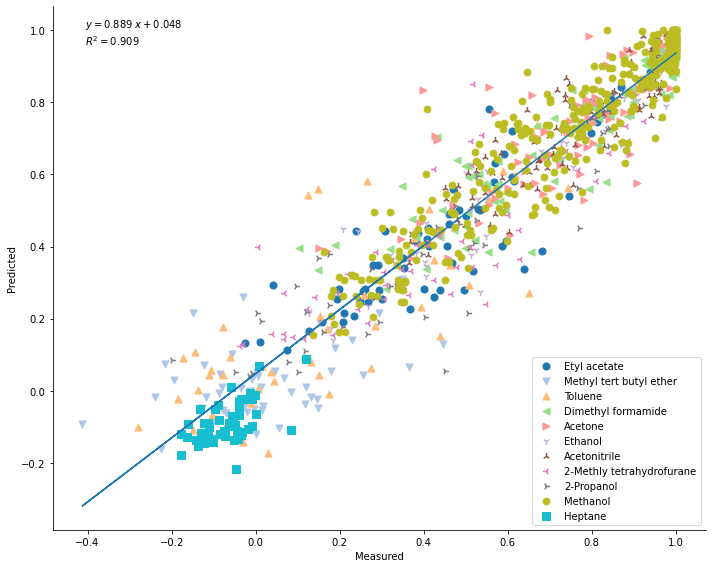

In [98]:
utils.rejection_diagram(data=meoh, x='dm300', y='dm300_measured', x_axis='Measured', y_axis="Predicted", group='solvent_name')

In [3]:
arguments = [
    '--test_path',  './data/FINAL_LIST.csv',
    '--preds_path', './data/predictions/hyperopt/_temp_FINAL_LIST.csv',
    '--checkpoint_dir', './data/train_results/hyperopt/10_fold/',
    '--smiles_column', 'full_smiles'
    ]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)

Loading training args
Setting molecule featurization parameters to default.
Loading data


1032it [00:00, 137561.87it/s]
100%|███████████████████████████████████| 1032/1032 [00:00<00:00, 173668.82it/s]


Validating SMILES
Test size = 1,032
Predicting with an ensemble of 10 models



  0%|                                                    | 0/10 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Moving model to cuda



 10%|████▍                                       | 1/10 [00:03<00:34,  3.79s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Moving model to cuda



 20%|████████▊                                   | 2/10 [00:04<00:16,  2.04s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Moving model to cuda



 30%|█████████████▏                              | 3/10 [00:05<00:11,  1.58s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Moving model to cuda



 40%|█████████████████▌                          | 4/10 [00:06<00:08,  1.38s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Moving model to cuda



 50%|██████████████████████                      | 5/10 [00:07<00:06,  1.27s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Moving model to cuda



 60%|██████████████████████████▍                 | 6/10 [00:08<00:04,  1.21s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Moving model to cuda



 70%|██████████████████████████████▊             | 7/10 [00:10<00:03,  1.21s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Moving model to cuda



 80%|███████████████████████████████████▏        | 8/10 [00:11<00:02,  1.14s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Moving model to cuda



 90%|███████████████████████████████████████▌    | 9/10 [00:11<00:01,  1.04s/it]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Loading pretrained parameter "ffn.7.weight".
Loading pretrained parameter "ffn.7.bias".
Moving model to cuda



100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]

Saving predictions to ./data/predictions/hyperopt/_temp_FINAL_LIST.csv
Elapsed time = 0:00:13


In [6]:
meoh = pd.read_csv(r'./data/predictions/hyperopt/_temp_FINAL_LIST.csv')
_ = pd.read_csv('./data/FINAL_LIST.csv')
meoh['measured'] = _['dm300']

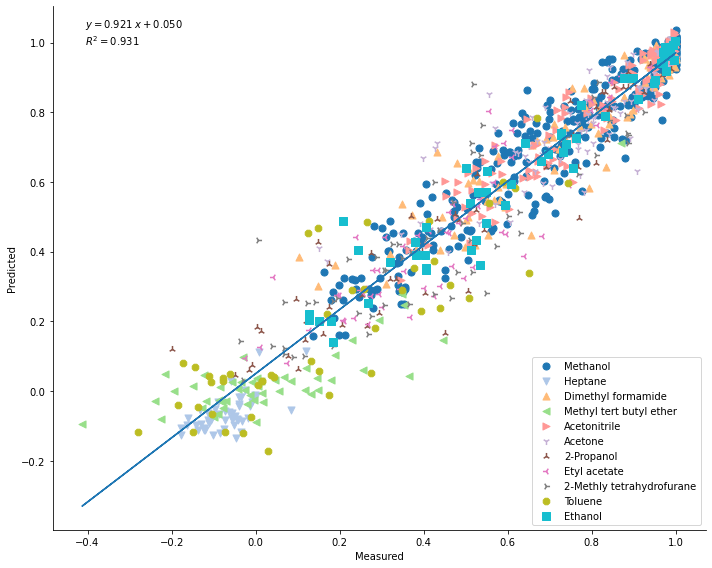

In [7]:
utils.rejection_diagram(data=meoh, x='measured', y='dm300', x_axis='Measured', y_axis="Predicted", group='solvent_name')